In [126]:
#!pip install xgboost
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score,mean_squared_error,accuracy_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV



# Data Preparation

In [127]:
df = pd.read_csv('../data/processed/crossfit_db.csv')

In [128]:
#removing null values
df = df.dropna()

# Model

In [129]:
scaler = StandardScaler()

In [130]:
drop_features = ['year', 'firstName', 'lastName', 'status', 'gender', 
                 'rank_2023_1', 'rank_2023_2', 'rank_2023_3','rank_2023_4',
                 'countryOfOriginCode', 'regionId', 'affiliateId', 'affiliateName',
                 'competitorName', 'countryOfOriginName', 'regionName' ,
                 'overallRank', 'overall_score_2023',
                 'score_reps_2023_1', 'score_reps_2023_2','score_reps_2023_3','score_reps_2023_4', 'score_time_2023_4'
                 ]

X = df.drop(columns=drop_features)
y = df["overall_score_2023"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = XGBRegressor(max_depth=5,  random_state=42)
model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Evaluate Model

In [131]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [132]:
y_pred = model.predict(X_test_scaled)

print('R2:', r2_score(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

error = mean_absolute_percentage_error(y_pred, y_test)
print("Mean absolute percentage error {0:.2f}%".format(error))

R2: 0.8128818355525483
MAE: 33396.72697930151
RMSE: 47997.75600798054
Mean absolute percentage error 28.76%


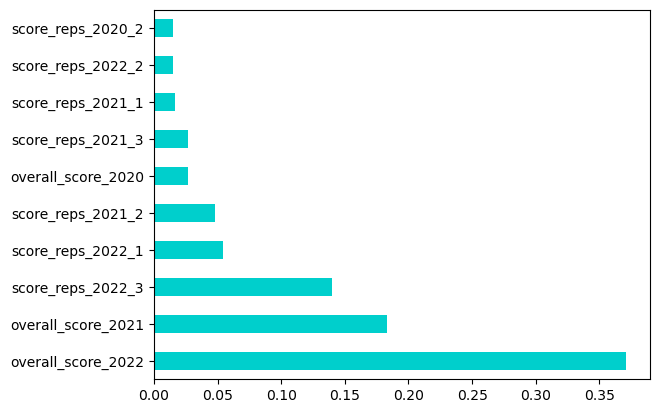

In [143]:
reg= ExtraTreesRegressor()
reg.fit(X_train,y_train)

feat_importances = pd.Series(reg.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh', color='#00cfcc')
plt.show()

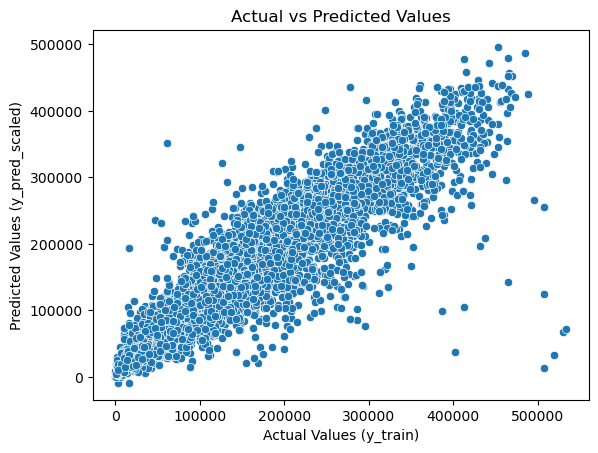

In [32]:
sns.scatterplot(x=y_test, y=y_pred)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values (y_train)')
plt.ylabel('Predicted Values (y_pred_scaled)')
plt.show()

# GridSearch

In [33]:
rf_param_grid = {
        'min_child_weight': [10, 50, 100, 200, 500],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [1, 2, 3, 4, 5]
}

rf_reg = XGBRegressor(random_state = 42)

# Setup grid search
rf_grid = GridSearchCV(estimator = rf_reg, param_grid = rf_param_grid, cv=10, refit=True)

# Fit the grid search model on training dataset
rf_grid.fit(X_train_scaled, y_train)

# Get best RF estimator based on best parameters, and use RF regressor to predict on test set
rf_best = rf_grid.best_estimator_
y_pred = rf_best.predict(X_test_scaled)

print('Best parameters:', rf_grid.best_params_)

Best parameters: {'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 2, 'min_child_weight': 200, 'subsample': 1.0}


In [46]:
print('R2:', r2_score(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

error = mean_absolute_percentage_error(y_pred, y_test)
print("Mean absolute percentage error {0:.2f}%".format(error))

R2: 0.8221417272108346
MAE: 32543.397100705326
RMSE: 46795.05851403412
Mean absolute percentage error 27.93%


In [50]:
#checking the model on train set
y_pred_2 = rf_best.predict(X_train_scaled)

print('R2:', r2_score(y_train, y_pred_2))
print('MAE:', mean_absolute_error(y_train, y_pred_2))
print('RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_2)))

error = mean_absolute_percentage_error(y_pred_2, y_train)
print("Mean absolute percentage error {0:.2f}%".format(error))

R2: 0.8446670599952326
MAE: 31532.106892960524
RMSE: 43898.04654977276
Mean absolute percentage error 26.31%


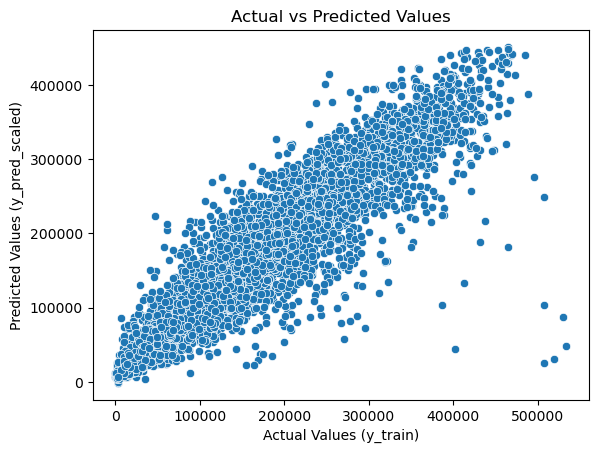

In [47]:
sns.scatterplot(x=y_test, y=y_pred)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values (y_train)')
plt.ylabel('Predicted Values (y_pred_scaled)')
plt.show()

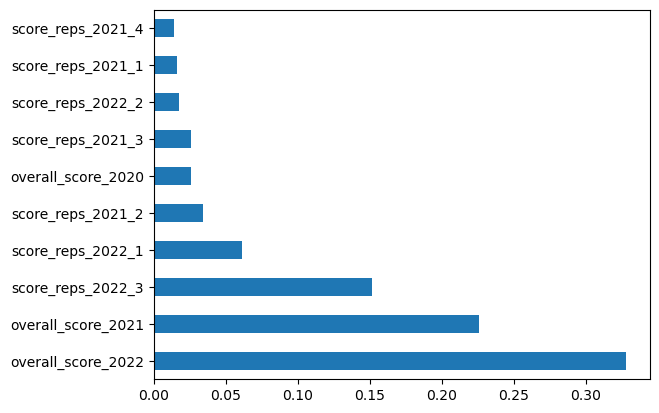

In [36]:
reg= ExtraTreesRegressor()
reg.fit(X_train,y_train)

feat_importances = pd.Series(reg.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

# Evaluate Prediction

In [144]:
#create a dataframe to check the results
df_check = X_test.copy()
df_check['y_pred'] = y_pred
df_check

,age,height,weight,overall_score_2022,score_reps_2022_1,score_reps_2022_2,score_reps_2022_3,overall_score_2021,score_reps_2021_1,score_reps_2021_2,...,score_reps_2020_2,score_reps_2020_1,score_time_2020_1,score_reps_2020_3,score_time_2020_3,score_reps_2020_4,score_time_2020_4,score_reps_2020_5,score_time_2020_5,y_pred
64399,29,186.000000,93.000000,122857.0,211.0,145.0,168.0,246001.0,222.0,1124.0,...,431.0,148,900,62,540,133,1200,201,1200,219269.468750
65903,43,178.778984,86.334657,142539.0,236.0,126.0,163.0,173529.0,387.0,1165.0,...,503.0,180,826,90,540,120,1200,216,1200,219087.718750
25415,37,175.696535,78.363154,72168.0,242.0,144.0,651.0,116387.0,387.0,995.0,...,510.0,164,900,156,540,160,1200,207,1200,136703.062500
11259,40,170.180000,70.306901,59049.0,248.0,147.0,578.0,75272.0,391.0,977.0,...,680.0,166,900,113,540,181,1200,240,1033,103084.226562
50557,31,185.420000,97.522476,102208.0,258.0,155.0,156.0,142749.0,374.0,1052.0,...,565.0,180,871,59,540,188,1200,200,1200,185514.234375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7820,35,177.000000,83.000000,27949.0,271.0,167.0,527.0,61127.0,389.0,882.0,...,616.0,180,898,103,540,160,1200,240,1100,82125.023438
10783,31,178.000000,90.000000,42819.0,242.0,180.0,643.0,60237.0,379.0,813.0,...,717.0,180,864,92,540,201,1200,240,1103,83932.898438
22960,32,180.000000,81.000000,55570.0,256.0,151.0,642.0,67344.0,388.0,891.0,...,617.0,180,893,115,540,160,1200,240,1124,91127.570312
10872,33,182.000000,92.000000,31574.0,281.0,174.0,682.0,45185.0,399.0,853.0,...,529.0,179,900,111,540,200,1200,240,1179,65231.683594


In [145]:
df_check = df_check.merge(df[['overall_score_2023']],left_index=True, right_index=True)
df_check
df_check['diff_score'] = df_check['overall_score_2023'] - df_check['y_pred']
df_check['diff_score'] = df_check['diff_score'].apply(lambda x: round(x, 0))
df_check

,age,height,weight,overall_score_2022,score_reps_2022_1,score_reps_2022_2,score_reps_2022_3,overall_score_2021,score_reps_2021_1,score_reps_2021_2,...,score_time_2020_1,score_reps_2020_3,score_time_2020_3,score_reps_2020_4,score_time_2020_4,score_reps_2020_5,score_time_2020_5,y_pred,overall_score_2023,diff_score
64399,29,186.000000,93.000000,122857.0,211.0,145.0,168.0,246001.0,222.0,1124.0,...,900,62,540,133,1200,201,1200,219269.468750,271447,52178.0
65903,43,178.778984,86.334657,142539.0,236.0,126.0,163.0,173529.0,387.0,1165.0,...,826,90,540,120,1200,216,1200,219087.718750,276683,57595.0
25415,37,175.696535,78.363154,72168.0,242.0,144.0,651.0,116387.0,387.0,995.0,...,900,156,540,160,1200,207,1200,136703.062500,127982,-8721.0
11259,40,170.180000,70.306901,59049.0,248.0,147.0,578.0,75272.0,391.0,977.0,...,900,113,540,181,1200,240,1033,103084.226562,70511,-32573.0
50557,31,185.420000,97.522476,102208.0,258.0,155.0,156.0,142749.0,374.0,1052.0,...,871,59,540,188,1200,200,1200,185514.234375,223483,37969.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7820,35,177.000000,83.000000,27949.0,271.0,167.0,527.0,61127.0,389.0,882.0,...,898,103,540,160,1200,240,1100,82125.023438,53846,-28279.0
10783,31,178.000000,90.000000,42819.0,242.0,180.0,643.0,60237.0,379.0,813.0,...,864,92,540,201,1200,240,1103,83932.898438,68395,-15538.0
22960,32,180.000000,81.000000,55570.0,256.0,151.0,642.0,67344.0,388.0,891.0,...,893,115,540,160,1200,240,1124,91127.570312,118317,27189.0
10872,33,182.000000,92.000000,31574.0,281.0,174.0,682.0,45185.0,399.0,853.0,...,900,111,540,200,1200,240,1179,65231.683594,68769,3537.0


/opt/homebrew/Caskroom/miniconda/base/envs/mba_final/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Boxplot without outliers')

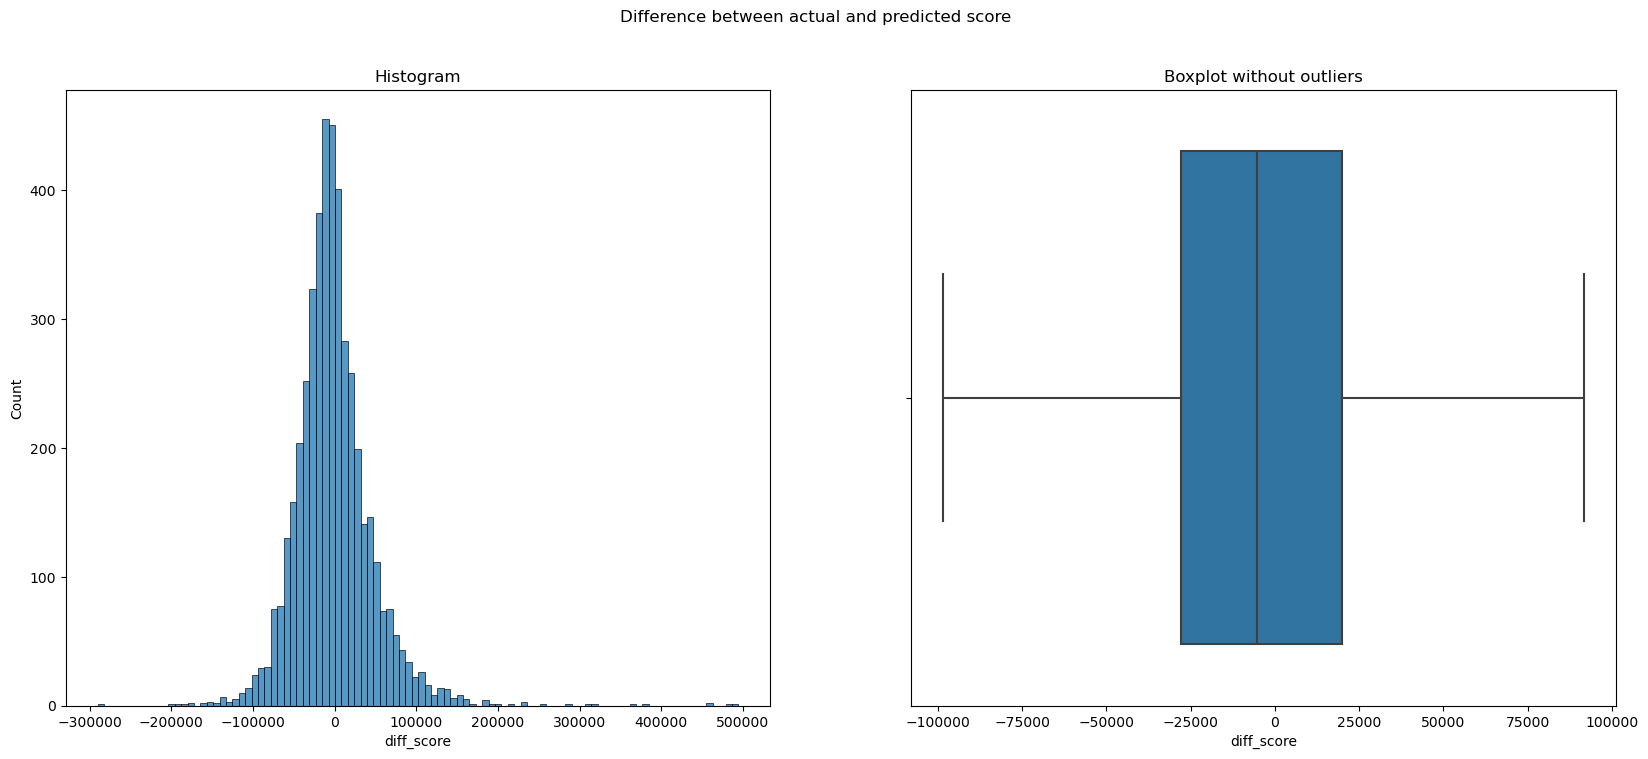

In [146]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

fig.suptitle('Difference between actual and predicted score')

sns.histplot(ax=axes[0], data=df_check, x="diff_score", bins=100).set_title('Histogram')
sns.boxplot(ax=axes[1], data=df_check, x="diff_score", showfliers=False).set_title('Boxplot without outliers')

In [147]:
df_check.describe()

,age,height,weight,overall_score_2022,score_reps_2022_1,score_reps_2022_2,score_reps_2022_3,overall_score_2021,score_reps_2021_1,score_reps_2021_2,...,score_time_2020_1,score_reps_2020_3,score_time_2020_3,score_reps_2020_4,score_time_2020_4,score_reps_2020_5,score_time_2020_5,y_pred,overall_score_2023,diff_score
count,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000,...,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000,4599.000000
mean,37.265710,178.344106,84.438216,110690.091107,227.940204,160.984562,332.680365,129777.823657,337.392042,788.618613,...,863.195477,90.470972,539.278539,173.205914,1199.053272,223.523592,1133.626875,169907.828125,168329.943466,-1577.873886
std,7.433558,4.735314,7.364799,78572.698570,47.899013,88.848535,202.998330,80748.438892,128.557793,330.089717,...,68.871831,34.827175,7.494440,34.463962,12.987513,17.720666,125.446451,103367.156250,110971.174036,47977.027470
min,19.000000,164.000000,62.000000,28.000000,1.000000,1.000000,1.000000,101.000000,1.000000,1.000000,...,496.000000,1.000000,379.000000,1.000000,761.000000,1.000000,611.000000,-9177.419922,107.000000,-289805.000000
25%,32.000000,175.260000,79.378759,43812.000000,196.000000,128.000000,163.000000,62933.500000,222.000000,700.500000,...,856.000000,66.000000,540.000000,160.000000,1200.000000,207.000000,1127.000000,84934.500000,78027.500000,-27950.500000
50%,37.000000,178.778984,84.821874,96191.000000,229.000000,146.000000,208.000000,120057.000000,375.000000,885.000000,...,900.000000,93.000000,540.000000,164.000000,1200.000000,228.000000,1200.000000,155363.578125,152245.000000,-5456.000000
75%,43.000000,180.889224,88.450617,166255.000000,262.000000,165.000000,536.000000,189435.500000,385.000000,1029.000000,...,900.000000,112.000000,540.000000,200.000000,1200.000000,240.000000,1200.000000,244857.585938,245698.500000,19904.500000
max,54.000000,192.000000,107.000000,333564.000000,390.000000,599.000000,719.000000,359015.000000,899.000000,1199.000000,...,900.000000,164.000000,540.000000,240.000000,1200.000000,240.000000,1200.000000,496169.375000,533265.000000,494604.000000
